## CSE 8803: Brain-inspired Machine Intelligence

### Lab 2: Alignment between Spiking Neural Networks and Artificial Neural Networks

Objectives:
- Design a Convolutional Neural Network for image classification task with CIFAR10 dataset
- Spiking Neural Network implementation
  - Training from scratch
  - Conversion from CNN
    - Learn basic theories of converting SNN from ANN
    - Paper: [Conversion of Continuous-Valued Deep Networks to Efficient Event-Driven Networks for Image Classification](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2017.00682/full)
- Alignment between CNN and SNN
  - Activation/Kernel Visualization in CNN and SNN
  - Cosine similarity between CNN and SNN
  - Linear regression from SNN to CNN
  - Feature visualization (activation maximization) in a shallow CNN
- After-class questions (15 points)
  - Symmetric analysis of linear regression from CNN to SNN (3 points)
  - Kernel visualization in AlexNet (6 points)
  - Feature Visualization in AlexNet (6 points)

Submission guideline for this lab is the same as that of Lab 1.

### Part 1: Design a Convolutional Neural Network for image classification task with CIFAR10 dataset

Recall that in Lab 1, we designed a two-layer fully connected network for digit classification task. In this lab, we will extend it to a convolutional neural network to solve the image classification task with CIFAR10 dataset.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#### Download dataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# normalize data to a range of [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

cpu
Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

#### Visualize dataset

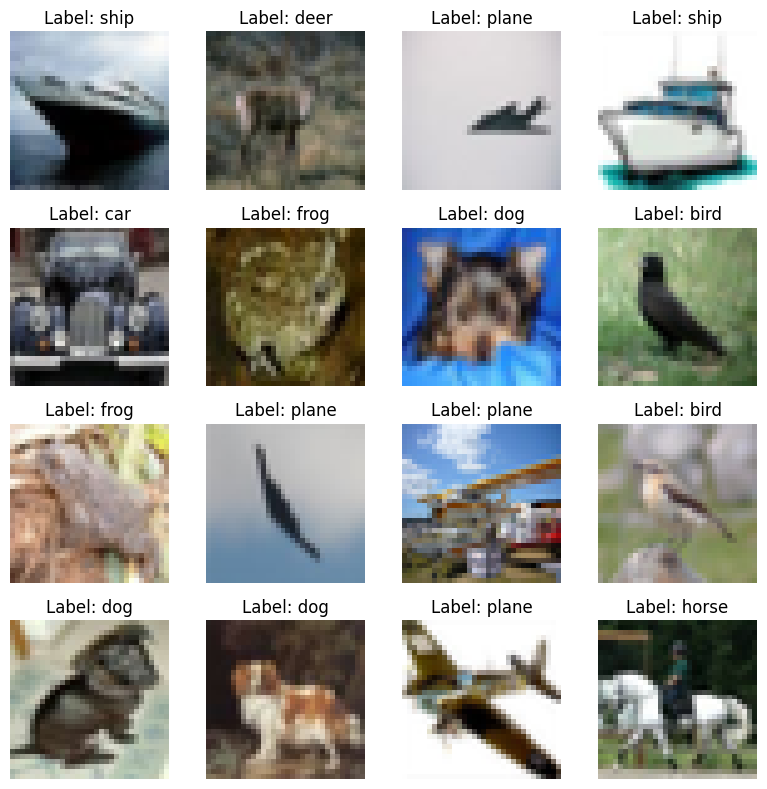

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# visualize the CIFAR10 dataset
# create an iterator over the DataLoader
data_iter = iter(train_loader)
# get the next batch of images and labels
images, labels = next(data_iter)

# visualize the images in a 4x4 grid
plt.figure(figsize=(8, 8))

# loop over the first 16 images
for i in range(16):
    # create a subplot for each image
    plt.subplot(4, 4, i + 1)
    img = images[i] / 2 + 0.5  # unnormalize
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(f'Label: {classes[labels[i].item()]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Design a Convolutional Neural Network

In [6]:
# define a convolutional neural network
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # first convolution and activation
        x = F.relu(self.bn1(self.conv1(x)))
        # second convolution and activation
        x = F.relu(self.bn2(self.conv2(x)))
        # flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
# instantiate the model
model_ann = ANN().to(device)

# define the number of epochs, loss function and optimizer
# use CrossEntropyLoss and Adam optimizer
epochs = 10
# softmax is already included in CELoss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ann.parameters(), lr=0.001)

# initialize lists to store loss and accuracy
train_losses_ann = []
test_losses_ann = []
test_accuracies_ann = []

In [8]:
# train the model in a single epoch
def train_ann(model, train_loader, criterion, optimizer, epoch):
    # set the model to training mode
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        # clear the gradients
        optimizer.zero_grad()
        # move data to GPU
        data, target = data.to(device), target.to(device)
        output = model(data)
        # compute loss
        loss = criterion(output, target)
        loss.backward()
        # update the weights
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)} / {len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # compute average loss in each epoch
    average_loss = running_loss / len(train_loader)
    return average_loss

# test the model in a single epoch
def test_ann(model, test_loader, criterion):
    # set the model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0

    # disable gradient calculation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += criterion(output, target).item()
            # get the index of the max output as the predicted category
            pred = output.argmax(dim=1, keepdim=True)
            # compute correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # average test loss
    test_loss /= len(test_loader.dataset)
    # accuracy percentage
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'-> Test: Average loss: {test_loss:.4f}, Accuracy: {correct} / {len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return accuracy, test_loss

In [9]:
max_test_accuracy_ann = 0

for epoch in range(epochs):
    average_loss = train_ann(model_ann, train_loader, criterion, optimizer, epoch)
    train_losses_ann.append(average_loss)
    accuracy, test_loss = test_ann(model_ann, test_loader, criterion)
    test_losses_ann.append(test_loss)
    test_accuracies_ann.append(accuracy)
    if accuracy >= max_test_accuracy_ann:
        max_test_accuracy_ann = accuracy

Train Epoch: 0 [0 / 50000 (0%)]	Loss: 2.333189
Train Epoch: 0 [6400 / 50000 (13%)]	Loss: 1.459027
Train Epoch: 0 [12800 / 50000 (26%)]	Loss: 1.352597
Train Epoch: 0 [19200 / 50000 (38%)]	Loss: 1.158669
Train Epoch: 0 [25600 / 50000 (51%)]	Loss: 1.056497
Train Epoch: 0 [32000 / 50000 (64%)]	Loss: 1.164476
Train Epoch: 0 [38400 / 50000 (77%)]	Loss: 1.101584
Train Epoch: 0 [44800 / 50000 (90%)]	Loss: 1.111513
-> Test: Average loss: 0.0113, Accuracy: 5893 / 10000 (59%)

Train Epoch: 1 [0 / 50000 (0%)]	Loss: 0.837600
Train Epoch: 1 [6400 / 50000 (13%)]	Loss: 1.138954
Train Epoch: 1 [12800 / 50000 (26%)]	Loss: 0.962932
Train Epoch: 1 [19200 / 50000 (38%)]	Loss: 0.800323
Train Epoch: 1 [25600 / 50000 (51%)]	Loss: 0.868482
Train Epoch: 1 [32000 / 50000 (64%)]	Loss: 1.167126
Train Epoch: 1 [38400 / 50000 (77%)]	Loss: 1.036133
Train Epoch: 1 [44800 / 50000 (90%)]	Loss: 0.818838
-> Test: Average loss: 0.0099, Accuracy: 6485 / 10000 (65%)

Train Epoch: 2 [0 / 50000 (0%)]	Loss: 0.849397
Train Epoch

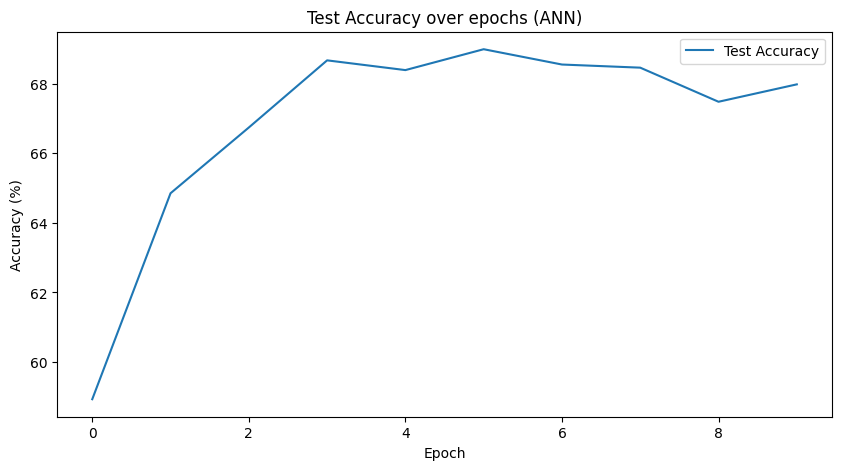

In [10]:
#plot testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), test_accuracies_ann, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over epochs (ANN)')
plt.legend()
plt.show()

### Part 2: Spiking Neural Network implementation: training from scratch or conversion from CNN

In [10]:
!pip install snntorch

In [11]:
import snntorch as snn
import snntorch.spikeplot as splt
from snntorch import surrogate
from IPython.display import HTML

#### Generate training data

In [12]:
def gen_spike_data_bernoulli(x, T):
    res = []
    for t in range(T):
        encoded_img = torch.bernoulli(x)
        res.append(encoded_img)
    return torch.stack(res)

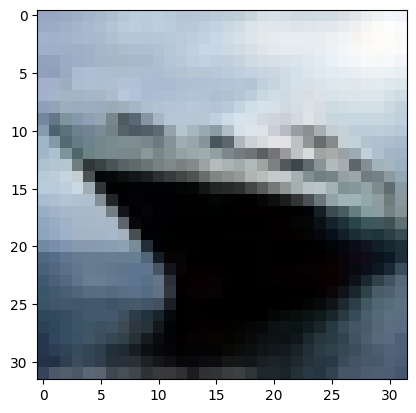

In [13]:
test_visualization_img = images[0] / 2 + 0.5  # unnormalize
test_visualization_img = test_visualization_img.permute(1, 2, 0)

# original image
plt.imshow(test_visualization_img)
plt.show()

torch.Size([25, 32, 32, 3])


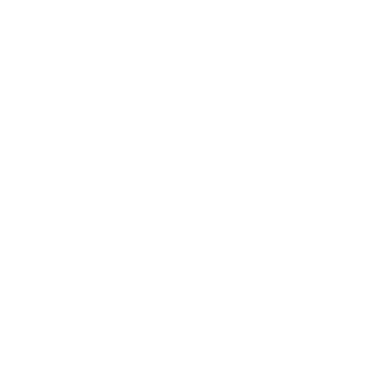

In [14]:
# generate spike train using Bernoulli
generated_spike_train = gen_spike_data_bernoulli(test_visualization_img, T=25)
print(generated_spike_train.shape)

fig, ax = plt.subplots()
anim = splt.animator(generated_spike_train, fig, ax)

HTML(anim.to_html5_video())

#### Design SNN counterpart of CNN

***Paper: [Conversion of Continuous-Valued Deep Networks to Efficient Event-Driven Networks for Image Classification](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2017.00682/full)***



---


**Theory 1 (the most important one)**: IF neuron in SNN is an unbiased estimator of ReLU activation function over time.

Proof: For the first layer of the neural network, the input layer, discuss the relationship between the firing rate of SNN neurons $r$ and the activation in the corresponding ANN. Assume that the input is constant as $z\in [0, 1]$. For the soft-reset neuron, its membrane potential $V$ changes with time as follows:

$$
V_{t} = V_{t-1} + z - o_{t} \cdot V_{th}
$$
where $V_{th}$ is the firing threshold, usually set to 1.0. $o_{t}$ is the output spike.

The average firing rate in the T time steps can be obtained by summing the membrane potential:

$$
\sum_{t=1}^T V_{t} = \sum_{t=1}^T V_{t-1} + zT - V_{th}\sum_{t=1}^T o_t
$$

Move all the items containing $V_t$ to the left, and divide both sides by $T$
$$
\frac{V_T-V_0}{T} = z - V_{th} \frac{\sum_{t=1}^T o_t}{T} = z - V_{th} \frac{N}{T}
$$
where $N$ is the number of spikes in the time step of $T$, and $\frac{N}{T}$ is the firing rate $r$. Therefore,
$$
r = \frac{z}{V_{th}} - \frac{V_T - V_0}{TV_{th}}
$$

Let $z = \alpha V_{th}$, when the simulation time step $T$ is infinite:
$$
r=\alpha \;(0 < \alpha < 1)
$$

In [15]:
# beta = 1: no decay for membrane potential
if_node = snn.Leaky(beta=1.0, reset_mechanism="subtract")

T = 128
# input current
x = torch.arange(-0.2, 1.2, 0.02)
print(x.shape)

torch.Size([70])


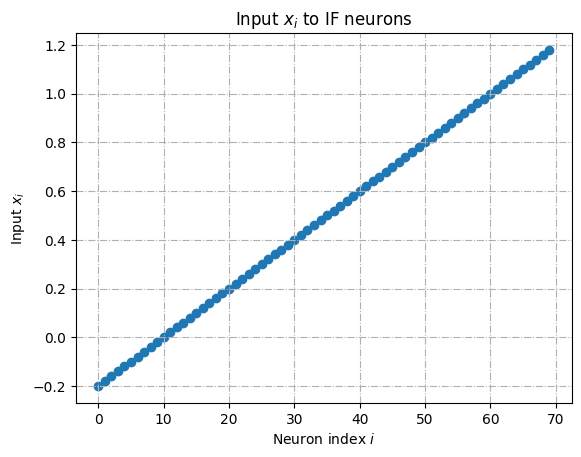

In [16]:
# plot input current for neurons
plt.scatter(torch.arange(x.shape[0]), x)
plt.title('Input $x_{i}$ to IF neurons')
plt.xlabel('Neuron index $i$')
plt.ylabel('Input $x_{i}$')
plt.grid(linestyle='-.')
plt.show()

In [17]:
# for every current stimuli, monitor the neuron's firing rate over T time steps
firing_rates = torch.zeros_like(x)
for idx, current in enumerate(x):
    # Reset neuron state
    mem = torch.zeros(1)
    spike_count = 0

    # T time steps
    for t in range(T):
        spk, mem = if_node(current, mem)
        spike_count += spk.item()

    # Calculate firing rate as number of spikes per total time
    firing_rates[idx] = spike_count / T

print(firing_rates)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0156, 0.0391, 0.0547, 0.0781, 0.0938, 0.1172, 0.1328,
        0.1562, 0.1797, 0.1953, 0.2188, 0.2344, 0.2578, 0.2734, 0.2969, 0.3125,
        0.3359, 0.3594, 0.3750, 0.3984, 0.4141, 0.4375, 0.4531, 0.4766, 0.4922,
        0.5156, 0.5391, 0.5547, 0.5781, 0.5938, 0.6172, 0.6328, 0.6562, 0.6797,
        0.6953, 0.7188, 0.7344, 0.7578, 0.7734, 0.7969, 0.8125, 0.8359, 0.8594,
        0.8750, 0.8984, 0.9141, 0.9375, 0.9531, 0.9766, 0.9922, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


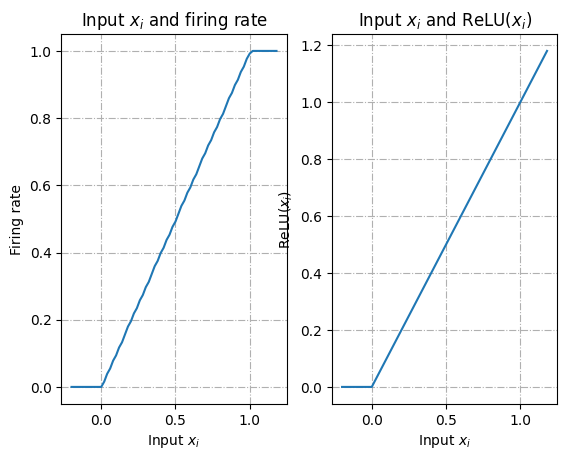

In [18]:
# firing rate under different current input
plt.subplot(1, 2, 1)
plt.plot(x, firing_rates)
plt.title('Input $x_{i}$ and firing rate')
plt.xlabel('Input $x_{i}$')
plt.ylabel('Firing rate')
plt.grid(linestyle='-.')

# ReLU activation
plt.subplot(1, 2, 2)
plt.plot(x, x.relu())
plt.title('Input $x_{i}$ and ReLU($x_{i}$)')
plt.xlabel('Input $x_{i}$')
plt.ylabel('ReLU($x_{i}$)')
plt.grid(linestyle='-.')
plt.show()

It can be found that the two curves are almost the same. It also should be noted that the firing rate cannot be higher than 1, so the IF neuron cannot fit the input of the ReLU in the ANN that is larger than 1.

##### SNN with two convolutional layers (BN) and two fully connected layers, all activated by IF neurons

Here, we will use `snntorch` API to instantiate a IF neuron and set leaky rate, reset machanism and surrogate gradient function.

In [19]:
# define a SNN with surrogate gradient descent
spike_grad1 = surrogate.fast_sigmoid(slope=1)

class SNN(nn.Module):
    def __init__(self, T):
        super(SNN, self).__init__()
        self.T = T
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # TODO: add your implementation here.
        self.if1 = snn.Leaky(beta=1.0, reset_mechanism="subtract", spike_grad=spike_grad1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.if2 = snn.Leaky(beta=1.0, reset_mechanism="subtract", spike_grad=spike_grad1)
        self.fc1 = nn.Linear(32 * 8 * 8, 512)
        self.if3 = snn.Leaky(beta=1.0, reset_mechanism="subtract", spike_grad=spike_grad1)
        self.fc2 = nn.Linear(512, 10)
        self.if4 = snn.Leaky(beta=1.0, reset_mechanism="subtract", spike_grad=spike_grad1)

    def forward(self, input_):
        # initialize membrane potential to 0
        mem1 = self.if1.init_leaky()
        mem2 = self.if2.init_leaky()
        mem3 = self.if3.init_leaky()
        mem4 = self.if4.init_leaky()

        # shape of x: [T, batch_size, 3, 32, 32]
        output_spikes = torch.zeros(input_.size(1), 10).to(device)
        for t in range(self.T):
            x = input_[t]
            # first convolution
            cur1 = self.bn1(self.conv1(x))
            spk1, mem1 = self.if1(cur1, mem1)
            # second convolution
            cur2 = self.bn2(self.conv2(spk1))
            spk2, mem2 = self.if2(cur2, mem2)
            # flatten the output for the fully connected layer
            spk2 = spk2.view(x.size(0), -1)
            cur3 = self.fc1(spk2)
            spk3, mem3 = self.if3(cur3, mem3)
            cur4 = self.fc2(spk3)
            spk4, mem4 = self.if4(cur4, mem4)
            output_spikes += spk4

        return output_spikes / T

##### Train SNN from scratch

In [20]:
def train_snn(model, train_loader, criterion, optimizer, epoch, T=5):
    # set the model to training mode
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        # clear the gradients
        optimizer.zero_grad()
        # move data to GPU
        data, target = data.to(device), target.to(device)
        target_onehot = F.one_hot(target, 10).float()
        data = data / 2 + 0.5
        output_fr = model(gen_spike_data_bernoulli(data, T))
        # compute the loss
        loss = criterion(output_fr, target_onehot)
        loss.backward()
        # update the weights
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)} / {len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # compute average loss in each epoch
    average_loss = running_loss / len(train_loader)
    return average_loss

In [21]:
def test_snn(model, test_loader, criterion, T=50):
    # set the model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0

    # disable gradient calculation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target_onehot = F.one_hot(target, 10).float()
            data = data / 2 + 0.5
            output_fr = model(gen_spike_data_bernoulli(data, T))
            # sum up batch loss
            test_loss += criterion(output_fr, target_onehot).item()
            # get the index of the max output as the predicted category
            pred = output_fr.argmax(dim=1, keepdim=True)
            # compute correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # average test loss
    test_loss /= len(test_loader.dataset)
    # accuracy percentage
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'-> Test: Average loss: {test_loss:.4f}, Accuracy: {correct} / {len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return accuracy, test_loss

In [22]:
T = 10
model_snn = SNN(T).to(device)
epochs = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(model_snn.parameters(), lr=0.001)
train_losses_snn = []
test_losses_snn = []
test_accuracies_snn = []

In [23]:
max_test_accuracy_snn = 0

# train and test the model
for epoch in range(epochs):
    train_loss = train_snn(model_snn, train_loader, criterion, optimizer, epoch, T)
    train_losses_snn.append(train_loss)
    accuracy, test_loss = test_snn(model_snn, test_loader, criterion, T)
    test_losses_snn.append(test_loss)
    test_accuracies_snn.append(accuracy)
    if accuracy >= max_test_accuracy_snn:
        max_test_accuracy_snn = accuracy

Train Epoch: 0 [0 / 50000 (0%)]	Loss: 0.095813
Train Epoch: 0 [6400 / 50000 (13%)]	Loss: 0.083094
Train Epoch: 0 [12800 / 50000 (26%)]	Loss: 0.075641
Train Epoch: 0 [19200 / 50000 (38%)]	Loss: 0.073766
Train Epoch: 0 [25600 / 50000 (51%)]	Loss: 0.075516
Train Epoch: 0 [32000 / 50000 (64%)]	Loss: 0.068031
Train Epoch: 0 [38400 / 50000 (77%)]	Loss: 0.073094
Train Epoch: 0 [44800 / 50000 (90%)]	Loss: 0.063281
-> Test: Average loss: 0.0007, Accuracy: 4658 / 10000 (47%)

Train Epoch: 1 [0 / 50000 (0%)]	Loss: 0.069781
Train Epoch: 1 [6400 / 50000 (13%)]	Loss: 0.067641
Train Epoch: 1 [12800 / 50000 (26%)]	Loss: 0.065703
Train Epoch: 1 [19200 / 50000 (38%)]	Loss: 0.075047
Train Epoch: 1 [25600 / 50000 (51%)]	Loss: 0.060984
Train Epoch: 1 [32000 / 50000 (64%)]	Loss: 0.065406
Train Epoch: 1 [38400 / 50000 (77%)]	Loss: 0.063938
Train Epoch: 1 [44800 / 50000 (90%)]	Loss: 0.061984
-> Test: Average loss: 0.0006, Accuracy: 5354 / 10000 (54%)

Train Epoch: 2 [0 / 50000 (0%)]	Loss: 0.058688
Train Epoch

##### Conversion from CNN

**Theory 2**: BatchNorm parameter absorption

ANN proposes Batch Normalization for fast training and convergence. Batch Normalization aims to normalize the ANN output to zero mean and unit variance, which is contrary to the properties of SNN. An input $x$ is transformed into $BN(\mathbf{x}) = \frac{\mathbf{\gamma}}{\sqrt{\mathbf{\sigma}^2 + \epsilon}}(\mathbf{x}-\mathbf{\mu}) + \mathbf{\beta}$, where mean $\mu$, variance $\sigma^2$, and the two learned parameters $\mathbf{\beta}$ and $\mathbf{\gamma}$ are all obtained during training. The parameters of BN can be absorbed into the previous parameter layers (Linear / Conv).

After training, these transformations can be integrated into the weight vectors, thereby preserving the effect of BN, but eliminating the need to compute the normalization repeatedly for each sample.

Specifically, we can set $\hat{\mathbf{W}} = \frac{\gamma}{\sigma}\mathbf{W}$ and $\hat{\mathbf{b}}=\frac{\gamma}{\sigma}(\mathbf{b}-\mu) + \beta$. This makes it simple to convert BN layers into SNNs, because after transforming the weights of the preceding layer, no additional conversion of BN layers is necessary.

**Theory 3**: Model Normalization

One source of approximation errors is that in time-stepped simulations of SNNs, the neurons are restricted to a firing rate less than 1, whereas ANNs typically do not have such constraints.

According to the transformation theory, the input and output of each layer of ANN need to be limited to the range of $[0, 1]$, which requires the scaling of the parameters. The *data-based weight normalization* mechanism is based on the linearity of the ReLU unit used for ANNs. It can simply be extended to biases by linearly rescaling all weights and biases such that the ANN activation is smaller than 1 for all training examples.

Denoting the maximum ReLU activation in layer $l$ as $\lambda_l = \max(\mathbf{a}^l)$, then weights $\mathbf{W}^l$ and biases $\mathbf{b}^l$ are normalized to $\mathbf{\hat{W}}^l = \mathbf{W}^l \frac{\lambda^{l-1}}{\lambda^l}$ and $\mathbf{\hat{b}}^l =\frac{\mathbf{b}^l}{\lambda^l}$.

### Part 3: Alignment between ANN and SNN

torch.Size([1, 3, 32, 32])


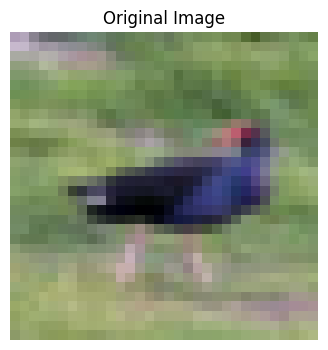

In [24]:
# randomly choose test sample from test loader
data_iter = iter(train_loader)
images, labels = next(data_iter)
first_image = images[0] / 2 + 0.5
first_image = first_image.to(device)
first_image = first_image.unsqueeze(0)
print(first_image.shape)

first_image_squeezed = first_image.squeeze(0)
first_image_np = first_image_squeezed.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(5, 4))

plt.imshow(first_image_np)
plt.title("Original Image")
plt.axis('off')
plt.show()

#### Visualization in ANN: layer activations & conv filters

- Layer activation: The most straight-forward visualization technique is to show the activations of the network during the forward pass.
- Conv filters: The second common strategy is to visualize the weights. These are usually most interpretable on the first CONV layer which is looking directly at the raw pixel data, but it is possible to also show the filter weights deeper in the network. The weights are useful to visualize because well-trained networks usually display nice and smooth filters without any noisy patterns. Noisy patterns can be an indicator of a network that hasn’t been trained for long enough, or possibly a very low regularization strength that may have led to overfitting.

In [25]:
# for simplicity, we provide pre-trained weights of ANN
!wget https://raw.githubusercontent.com/wang-zixuan/CSE8803_BMI/master/best_model_ann.pth

model_ann_vis = ANN().to(device)
model_ann_vis.load_state_dict(torch.load('best_model_ann.pth', weights_only=True))

--2024-09-24 15:51:11--  https://raw.githubusercontent.com/wang-zixuan/CSE8803_BMI/master/best_model_ann.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4264378 (4.1M) [application/octet-stream]
Saving to: ‘best_model_ann.pth.2’

best_model_ann.pth. 100%[===================>]   4.07M  10.9MB/s    in 0.4s    

2024-09-24 15:51:11 (10.9 MB/s) - ‘best_model_ann.pth.2’ saved [4264378/4264378]



<All keys matched successfully>

Layer activation - 1st conv

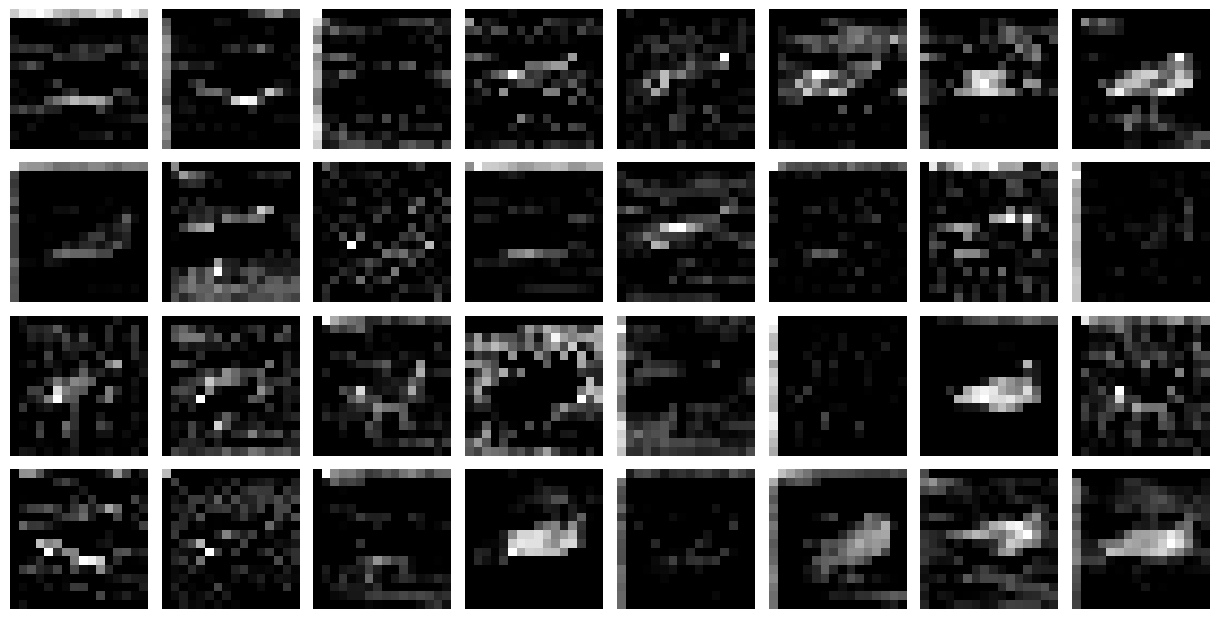

In [27]:
# first conv layer feature size: [32, 16, 16]
convbn1_cnn_out = F.relu(model_ann_vis.bn1(model_ann_vis.conv1(first_image)))

convbn1_cnn_out_squeezed = convbn1_cnn_out.squeeze(0)

def normalize_image(channel):
    return (channel - channel.min()) / (channel.max() - channel.min())

n_rows = 4
n_cols = 8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.1)

for i, ax in enumerate(axes.flat):
    channel_data = convbn1_cnn_out_squeezed[i].cpu().detach().numpy()
    channel_data = normalize_image(channel_data)
    ax.imshow(channel_data, cmap='gray', aspect='auto')
    ax.axis('off')

plt.show()

Layer activation - 2nd conv

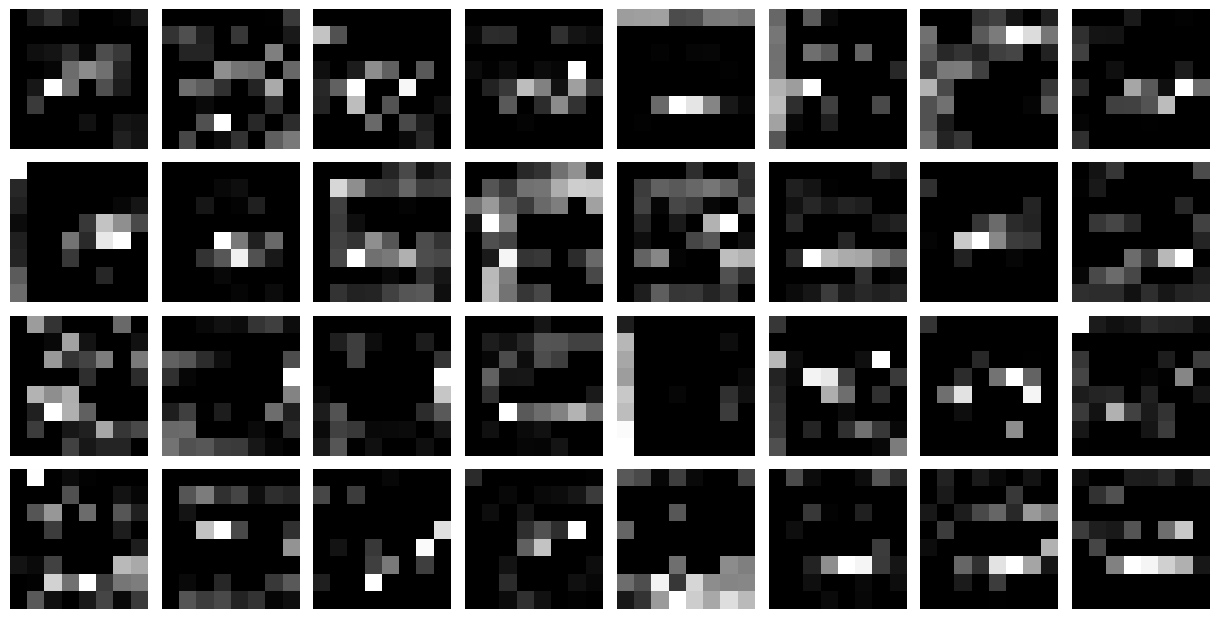

In [125]:
# second conv layer feature size: [32, 8, 8]
convbn2_cnn_out = F.relu(model_ann_vis.bn2(model_ann_vis.conv2(convbn1_cnn_out)))

convbn2_out_squeezed = convbn2_cnn_out.squeeze(0)

def normalize_image(channel):
    return (channel - channel.min()) / (channel.max() - channel.min())

n_rows = 4
n_cols = 8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.1)

for i, ax in enumerate(axes.flat):
    channel_data = convbn2_out_squeezed[i].cpu().detach().numpy()
    channel_data = normalize_image(channel_data)
    ax.imshow(channel_data, cmap='gray', aspect='auto')
    ax.axis('off')
plt.savefig('images/conv2_cnn.png')
plt.show()

Conv filter - 1st conv

torch.Size([32, 3, 3, 3])


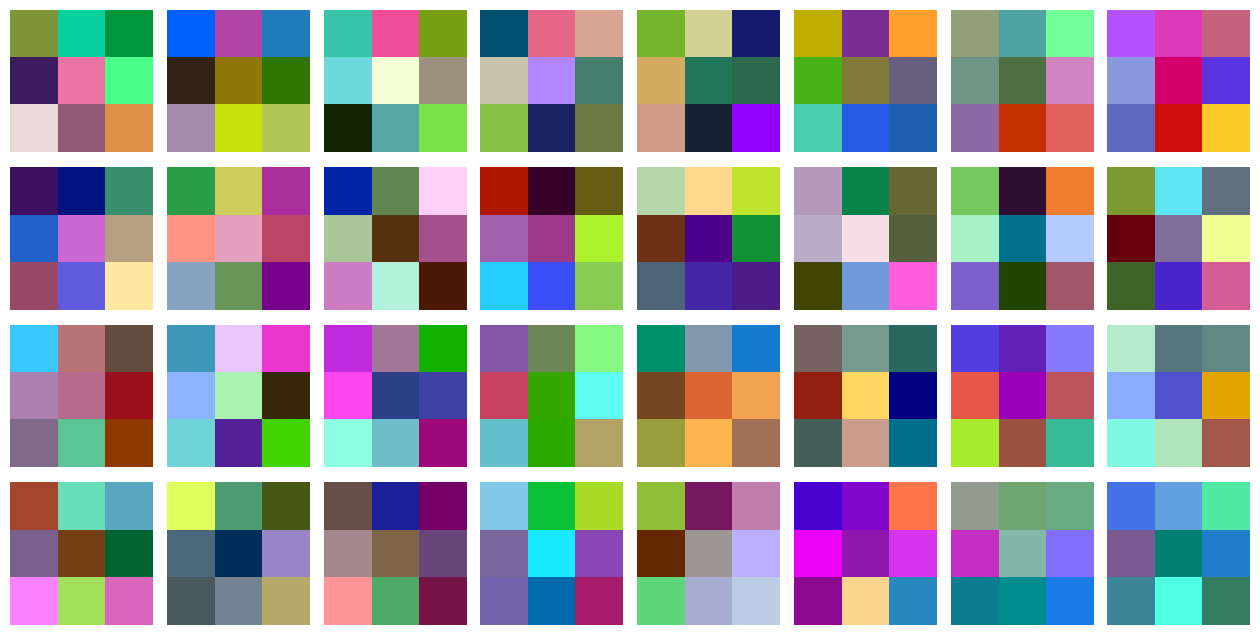

In [29]:
def normalize_kernel(kernel):
    kernel_min = kernel.min()
    kernel_max = kernel.max()
    return (kernel - kernel_min) / (kernel_max - kernel_min)

kernels_conv1_cnn = model_ann_vis.conv1.weight.data.cpu()
# [32, 3, 3, 3] - 32 output channels, 3 input channels
print(kernels_conv1_cnn.shape)

fig, axes = plt.subplots(4, 8, figsize=(8 * 2, 4 * 2))

for i, ax in enumerate(axes.flat):
    kernel = kernels_conv1_cnn[i]
    kernel = normalize_kernel(kernel)
    kernel = kernel.permute(1, 2, 0)
    ax.imshow(kernel)
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

Conv filter - 2nd conv

torch.Size([32, 32, 3, 3])


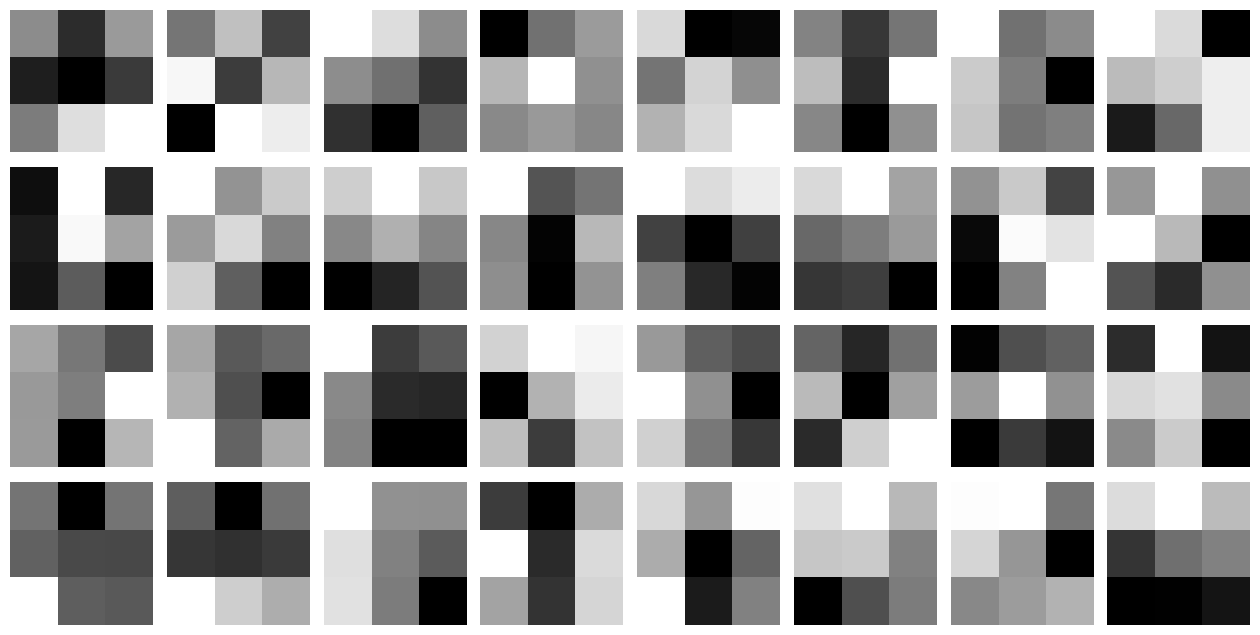

In [30]:
kernels_conv2_cnn = model_ann_vis.conv2.weight.data.cpu()
# [32, 32, 3, 3] - 32 output channels, 32 input channels
print(kernels_conv2_cnn.shape)

fig, axes = plt.subplots(4, 8, figsize=(8 * 2, 4 * 2))

for i, ax in enumerate(axes.flat):
    kernel = kernels_conv2_cnn[i].mean(0)
    ax.imshow(kernel, cmap='gray')
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

#### Visualization in SNN: layer activations & conv filters

In [31]:
spike_grad1 = surrogate.fast_sigmoid(slope=1)

class SNN_KernelVisualization(nn.Module):
    def __init__(self, T):
        super(SNN_KernelVisualization, self).__init__()
        self.T = T
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.if1 = snn.Leaky(beta=1.0, reset_mechanism="subtract", spike_grad=spike_grad1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.if2 = snn.Leaky(beta=1.0, reset_mechanism="subtract", spike_grad=spike_grad1)
        self.fc1 = nn.Linear(32 * 8 * 8, 512)
        self.if3 = snn.Leaky(beta=1.0, reset_mechanism="subtract", spike_grad=spike_grad1)
        self.fc2 = nn.Linear(512, 10)
        self.if4 = snn.Leaky(beta=1.0, reset_mechanism="subtract", spike_grad=spike_grad1)

    def forward(self, input_):
        # initialize membrane potential to 0
        mem1 = self.if1.init_leaky()
        mem2 = self.if2.init_leaky()
        mem3 = self.if3.init_leaky()
        mem4 = self.if4.init_leaky()

        # shape of x: [T, batch_size, 3, 32, 32]
        output_spikes = torch.zeros(input_.size(1), 10).to(device)
        convbn1_spikes = torch.zeros(input_.size(1), 32, 16, 16).to(device)
        convbn2_spikes = torch.zeros(input_.size(1), 32, 8, 8).to(device)
        for t in range(self.T):
            x = input_[t]
            # first convolution
            cur1 = self.bn1(self.conv1(x))
            spk1, mem1 = self.if1(cur1, mem1)
            convbn1_spikes += spk1
            # second convolution
            cur2 = self.bn2(self.conv2(spk1))
            spk2, mem2 = self.if2(cur2, mem2)
            convbn2_spikes += spk2
            # flatten the output for the fully connected layer
            spk2 = spk2.view(x.size(0), -1)
            cur3 = self.fc1(spk2)
            spk3, mem3 = self.if3(cur3, mem3)
            cur4 = self.fc2(spk3)
            spk4, mem4 = self.if4(cur4, mem4)
            output_spikes += spk4

        return output_spikes / T, convbn1_spikes / T, convbn2_spikes / T

In [32]:
!wget https://raw.githubusercontent.com/wang-zixuan/CSE8803_BMI/master/best_model_snn.pth

T = 10
model_snn_vis = SNN_KernelVisualization(T).to(device)
model_snn_vis.load_state_dict(torch.load('best_model_snn.pth', weights_only=True))

--2024-09-24 15:51:13--  https://raw.githubusercontent.com/wang-zixuan/CSE8803_BMI/master/best_model_snn.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4268666 (4.1M) [application/octet-stream]
Saving to: ‘best_model_snn.pth.6’

best_model_snn.pth. 100%[===================>]   4.07M  10.4MB/s    in 0.4s    

2024-09-24 15:51:14 (10.4 MB/s) - ‘best_model_snn.pth.6’ saved [4268666/4268666]



<All keys matched successfully>

Layer activation (firing rate) - 1st conv

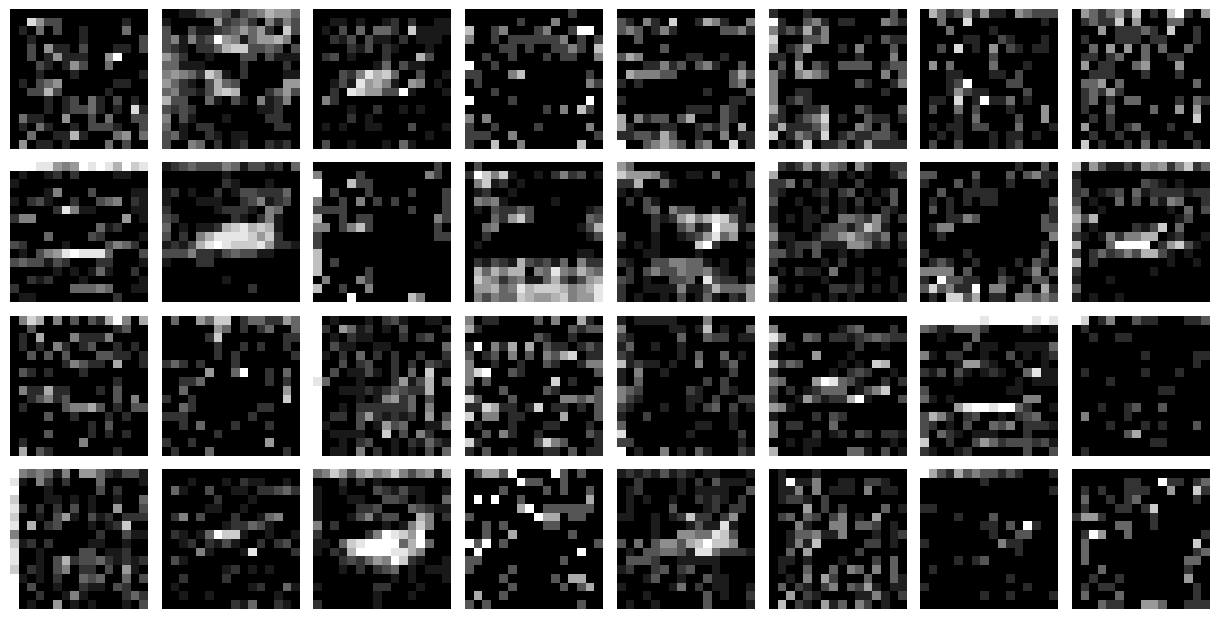

In [33]:
_, convbn1_snn_out, convbn2_snn_out = model_snn_vis(gen_spike_data_bernoulli(first_image, T))
convbn1_snn_out_squeezed = convbn1_snn_out.squeeze(0)
convbn2_snn_out_squeezed = convbn2_snn_out.squeeze(0)

def normalize_image(channel):
    return (channel - channel.min()) / (channel.max() - channel.min())

n_rows = 4
n_cols = 8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.1)

for i, ax in enumerate(axes.flat):
    channel_data = convbn1_snn_out_squeezed[i].cpu().detach().numpy()
    channel_data = normalize_image(channel_data)
    ax.imshow(channel_data, cmap='gray', aspect='auto')
    ax.axis('off')

plt.show()

Layer activation (firing rate) - 2nd conv

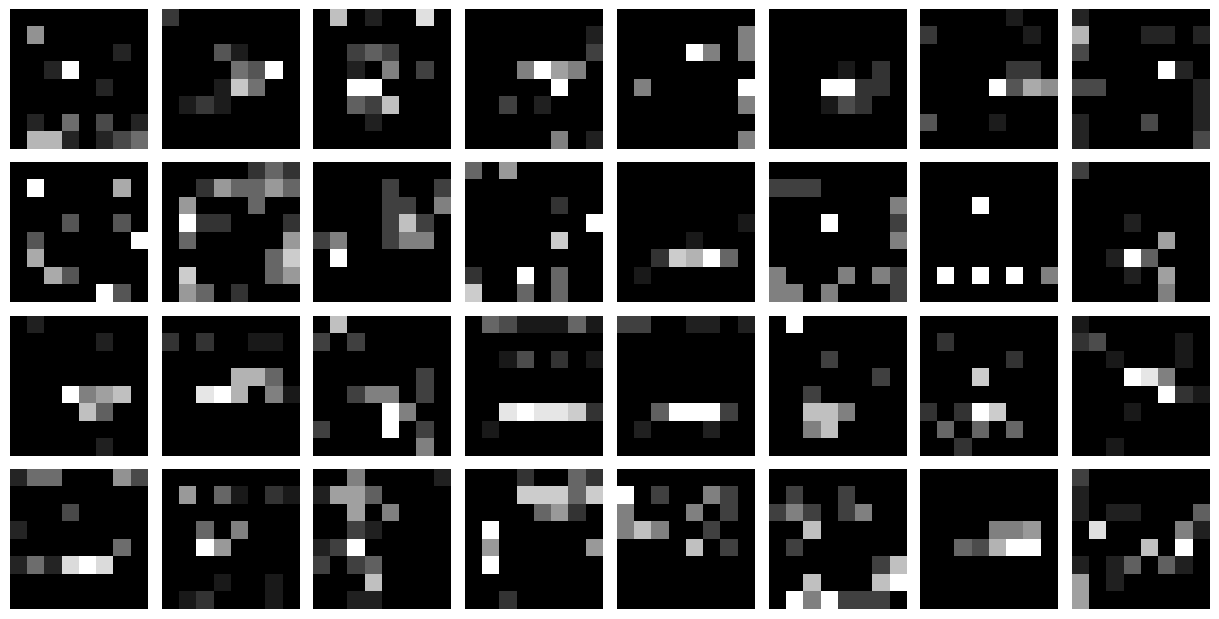

In [124]:
n_rows = 4
n_cols = 8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.1)

for i, ax in enumerate(axes.flat):
    channel_data = convbn2_snn_out_squeezed[i].cpu().detach().numpy()
    channel_data = normalize_image(channel_data)
    ax.imshow(channel_data, cmap='gray', aspect='auto')
    ax.axis('off')
plt.savefig('iamges/conv2_snn.png')
plt.show()

Conv filter - 1st conv

torch.Size([32, 3, 3, 3])


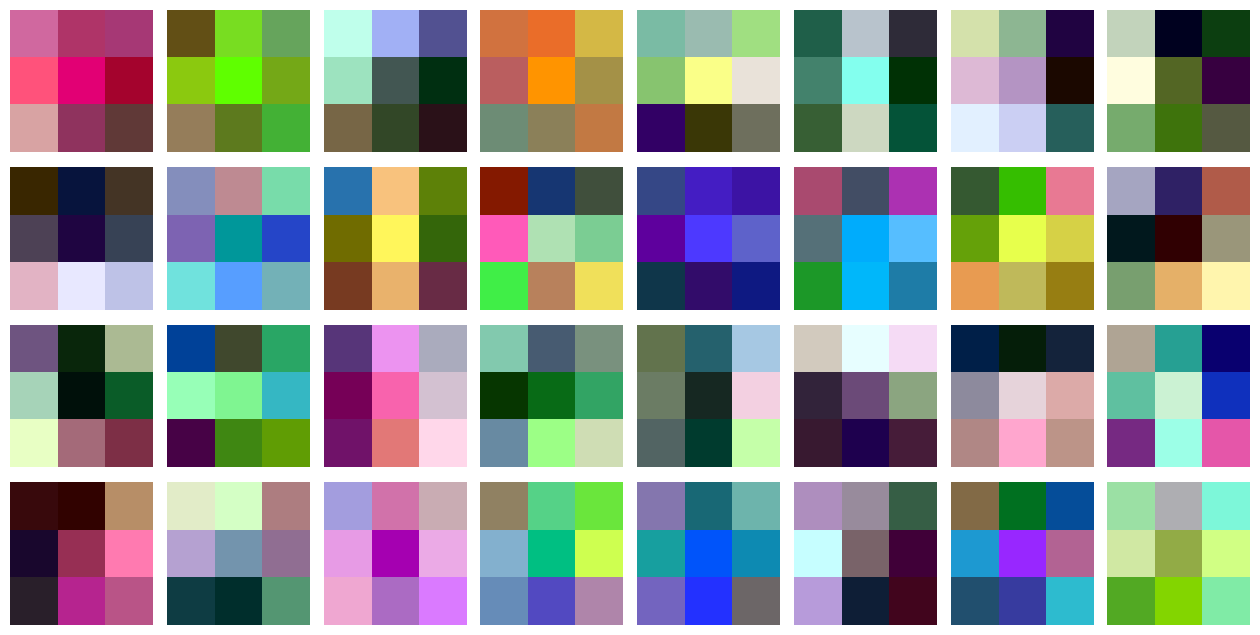

In [35]:
kernels_conv1_snn = model_snn_vis.conv1.weight.data.cpu()
# [32, 3, 3, 3] - 32 output channels, 3 input channels
print(kernels_conv1_snn.shape)

fig, axes = plt.subplots(4, 8, figsize=(8 * 2, 4 * 2))

for i, ax in enumerate(axes.flat):
    kernel = kernels_conv1_snn[i]
    kernel = normalize_kernel(kernel)
    kernel = kernel.permute(1, 2, 0)
    ax.imshow(kernel)
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

Conv filter - 2nd conv

torch.Size([32, 32, 3, 3])


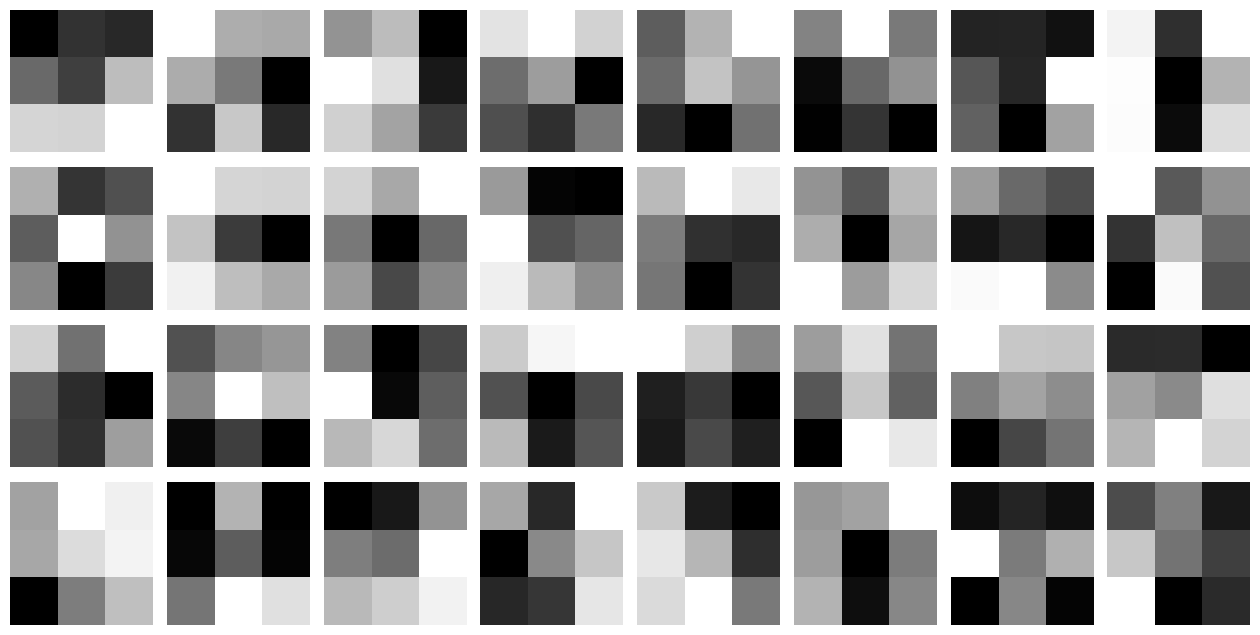

In [36]:
kernels_conv2_snn = model_snn_vis.conv2.weight.data.cpu()
# [32, 32, 3, 3] - 32 output channels, 32 input channels
print(kernels_conv2_snn.shape)

fig, axes = plt.subplots(4, 8, figsize=(8 * 2, 4 * 2))

for i, ax in enumerate(axes.flat):
    kernel = kernels_conv2_snn[i].mean(0).detach().numpy()
    ax.imshow(kernel, cmap='gray')
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

#### Cosine similarity between CNN and SNN

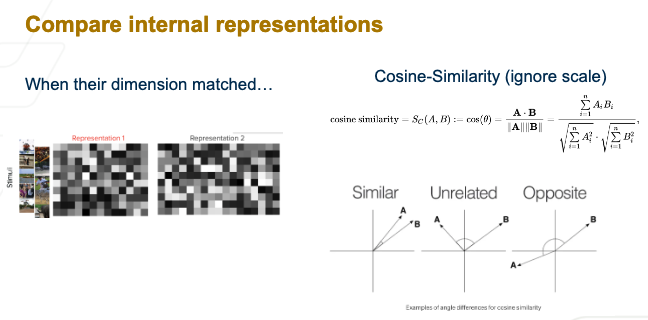

Cosine similarity is calculated as the cosine of the angle between two vectors. This measure is a reflection of the orientation of the two vectors in the space, rather than their magnitude.

The cosine similarity ranges from -1 to 1.
- A similarity of 1 indicates that the vectors are in the same direction.
- A similarity of 0 indicates no similarity.
- A similarity of -1 indicates that the vectors are in opposite directions.

In [37]:
model_ann_vis.eval()
model_snn_vis.eval()

res = 0
with torch.no_grad():
    # pass every test data to the model and get average cosine similarity
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        convbn2_cnn_out = F.relu(model_ann_vis.bn2(model_ann_vis.conv2(F.relu(model_ann_vis.bn1(model_ann_vis.conv1(data))))))
        data = data / 2 + 0.5
        _, _, convbn2_snn_out = model_snn_vis(gen_spike_data_bernoulli(data, T))
        # test loader batch size is 100
        convbn2_cnn_out_flat = convbn2_cnn_out.view(100, -1)
        convbn2_snn_out_flat = convbn2_snn_out.view(100, -1)
        # calculate over the feature dimension
        cosine_sim = F.cosine_similarity(convbn2_cnn_out_flat, convbn2_snn_out_flat, dim=1)
        res += cosine_sim.mean().item()

print(res / len(test_loader))

0.1685805580019951


A key take-away here is: even CNN and SNN have similar network structure and performance, their representation can be quite different.

#### Linear regression from SNN to CNN

Linear regression is another way to analyze the alignment between CNN and SNN. By linearly transforming features from one model to another, we can quantitatively measure (MSELoss) how similar these two types of networks are in terms of feature representation.

In [38]:
# SNN feature: convbn1_fr_flat; CNN feature: convbn1_output_output
# generate a new dataset for mapping SNN features to CNN features
convbn2_cnn_out_features = []
convbn2_snn_out_features = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)

        convbn2_cnn_out = F.relu(model_ann_vis.bn2(model_ann_vis.conv2(F.relu(model_ann_vis.bn1(model_ann_vis.conv1(data))))))
        # flatten to [100, 32 * 8 * 8]
        convbn2_cnn_out = convbn2_cnn_out.view(100, -1)
        # append cnn output to feature dataset
        convbn2_cnn_out_features.append(convbn2_cnn_out.cpu())

        data = data / 2 + 0.5
        _, _, convbn2_snn_out = model_snn_vis(gen_spike_data_bernoulli(data, T))
        convbn2_snn_out = convbn2_snn_out.view(100, -1)
        # append snn output to feature dataset
        convbn2_snn_out_features.append(convbn2_snn_out.cpu())

convbn2_cnn_out_features_dataset = torch.cat(convbn2_cnn_out_features, dim=0)
convbn2_snn_out_features_dataset = torch.cat(convbn2_snn_out_features, dim=0)
print(convbn2_cnn_out_features_dataset.shape)

torch.Size([10000, 2048])


In [39]:
epochs = 15
dataset_length = len(convbn2_snn_out_features_dataset)
# split dataset into training set and testing set, with 80% of data points being training set
train_dataset_length = int(0.8 * dataset_length)

In [40]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

dimension = 32 * 8 * 8
model = LinearRegressionModel(dimension, dimension)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
train_batch_size = 100

for epoch in range(epochs):
    train_loss = 0
    for i in range(0, train_dataset_length, train_batch_size):
        snn_feature = convbn2_snn_out_features_dataset[i: i + train_batch_size]
        cnn_feature = convbn2_cnn_out_features_dataset[i: i + train_batch_size]

        # remove gradient
        snn_feature = snn_feature.to(device).detach()
        cnn_feature = cnn_feature.to(device).detach()

        # Forward pass
        outputs = model(snn_feature)
        loss = criterion(outputs, cnn_feature)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {train_loss / (train_dataset_length / train_batch_size):.4f}')


test_loss = 0
with torch.no_grad():
    for i in range(train_dataset_length, dataset_length):
        snn_feature = convbn2_snn_out_features_dataset[i].unsqueeze(0)
        cnn_feature = convbn2_cnn_out_features_dataset[i].unsqueeze(0)
        # remove gradient
        snn_feature = snn_feature.to(device).detach()
        cnn_feature = cnn_feature.to(device).detach()

        outputs = model(snn_feature)
        loss = criterion(outputs, cnn_feature)
        test_loss += loss.item()

print(f'Test Loss: {test_loss / (dataset_length - train_dataset_length)}')

Epoch [1/15], Loss: 0.4950
Epoch [2/15], Loss: 0.3833
Epoch [3/15], Loss: 0.3401
Epoch [4/15], Loss: 0.3139
Epoch [5/15], Loss: 0.2959
Epoch [6/15], Loss: 0.2827
Epoch [7/15], Loss: 0.2726
Epoch [8/15], Loss: 0.2645
Epoch [9/15], Loss: 0.2580
Epoch [10/15], Loss: 0.2525
Epoch [11/15], Loss: 0.2480
Epoch [12/15], Loss: 0.2441
Epoch [13/15], Loss: 0.2407
Epoch [14/15], Loss: 0.2378
Epoch [15/15], Loss: 0.2352
Test Loss: 0.3203047851882875


#### Feature visualization (activation maximization) in a shallow CNN

Feature visualization answers questions about what a network — or parts of a network — are looking for by generating examples.

What do we want examples of? This is the core question in working with examples, regardless of whether we’re searching through a dataset to find the examples, or optimizing images to create them from scratch. We have a wide variety of options:

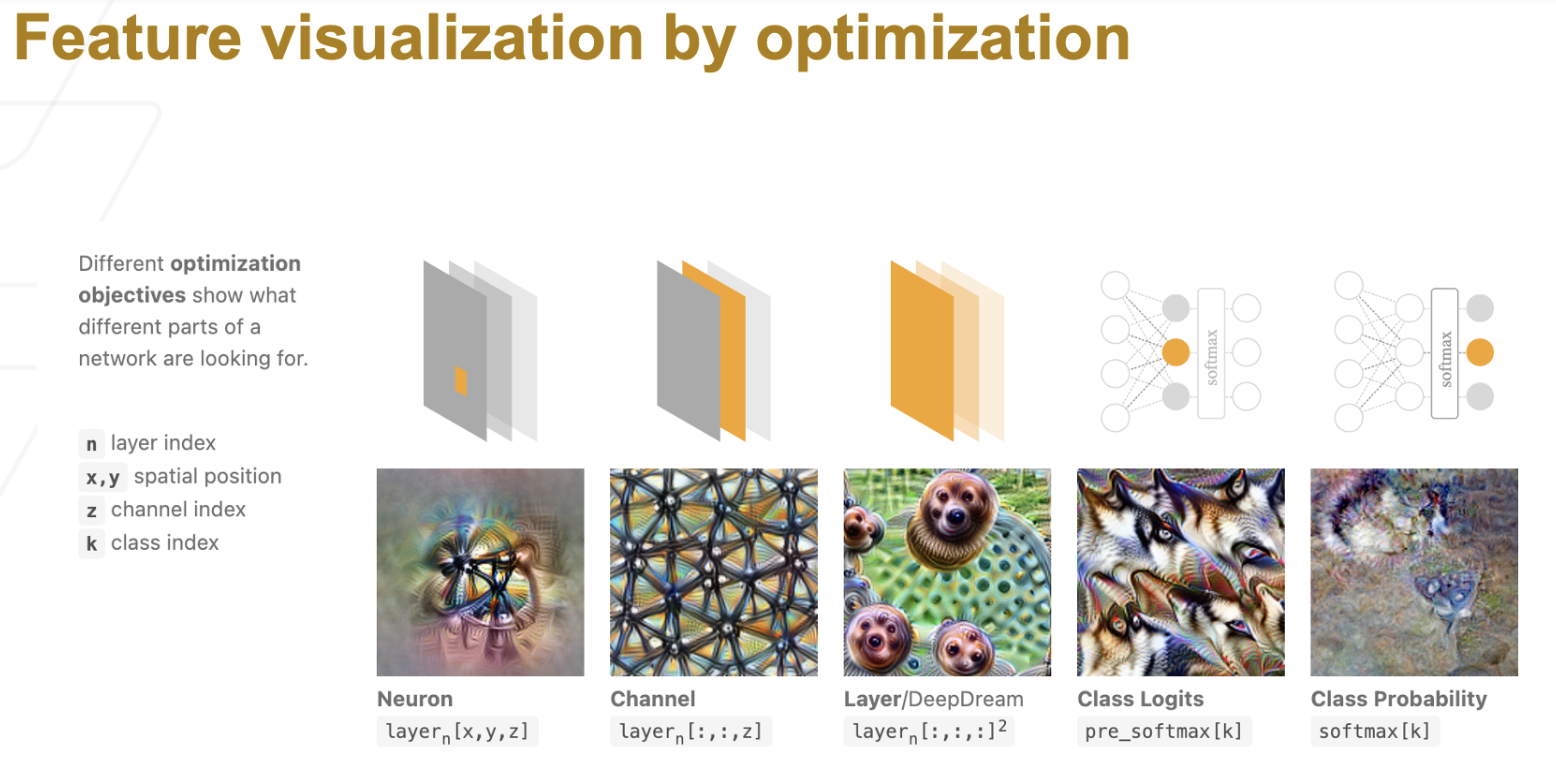

##### Feature visualization in CNN

In [41]:
model_ann_fea_vis = ANN().to(device)
model_ann_fea_vis.load_state_dict(torch.load('best_model_ann.pth', weights_only=True))

<All keys matched successfully>

In [42]:
class ActivationMaximization():
    def __init__(self, model, epochs, cnn_filter_idx):
        self.model = model
        # set model to evaluation mode
        self.model.eval()
        self.epochs = epochs
        # index of first dimension of feature map (channel-level)
        self.cnn_filter_idx = cnn_filter_idx
        # initialize the output of the model for loss
        self.conv_output = 0

    def hook_cnn_layer(self):
        # a forward hook to save the input and output from the selected layer
        def hook_fn(module, input, output):
            # size of output: [batch_size, channel, height, width]
            # TODO: add your implementation here.
            self.conv_output = output[0, self.cnn_filter_idx]
        # add hook to bn2
        self.model.bn2.register_forward_hook(hook_fn)

    def vis_cnn_layer(self):
        # initiate hook function
        self.hook_cnn_layer()
        # create a noisy image
        noisy_img = torch.randn(1, 3, 32, 32).to(device)
        # add dimension and activate requires_grad on tensor
        processed_image = noisy_img.requires_grad_()
        # define optimizer
        optimizer = optim.Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, self.epochs):
            optimizer.zero_grad()
            # pass data through the model
            x = self.model(processed_image)
            # then get output from hook and maximize it
            # TODO: add your implementation here.
            loss = -torch.mean(self.conv_output)
            # the weights of the model is not trainable, we only apply gradient to our input
            loss.backward()
            optimizer.step()

            if i % 5 == 0:
                print('loss: ', loss.item())
                plt.figure(figsize=[2, 2])
                plt.axis('off')
                plt.imshow(processed_image.detach().cpu().squeeze(0).permute(1, 2, 0))
                plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.8016295..4.42825].


loss:  -2.81058406829834


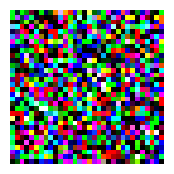

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.2819405..4.673919].


loss:  -8.033561706542969


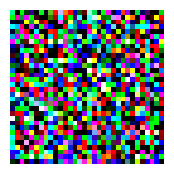

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.795453..5.0259104].


loss:  -12.724957466125488


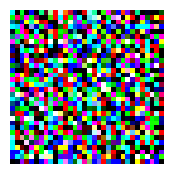

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.340017..5.283448].


loss:  -17.436494827270508


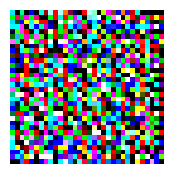

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.8801446..5.7181764].


loss:  -22.250835418701172


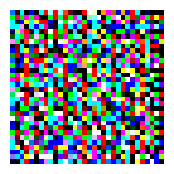

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.435567..6.14548].


loss:  -27.14632797241211


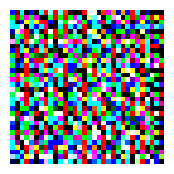

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.016455..6.5988574].


loss:  -32.142208099365234


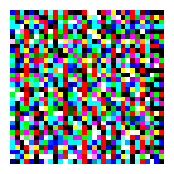

loss:  -37.24152755737305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.579205..7.125264].


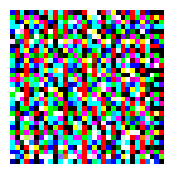

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.111103..7.7230697].


loss:  -42.428955078125


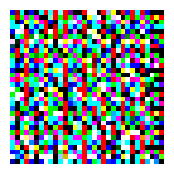

loss:  -47.674617767333984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.648888..8.33178].


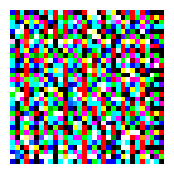

In [43]:
# channel level
cnn_filter_idx = 16
epochs = 51

activation_maximization = ActivationMaximization(model_ann_fea_vis, epochs, cnn_filter_idx)
activation_maximization.vis_cnn_layer()

It's not easy to maximize activation in SNN using back propagation since the activation is discretized. Alternatively, we can pass test dataset to the trained SNN model and find top K data points in terms of firing rate and average them to get the best input.

### Part 4: After-class questions

For each section, please share your findings and analysis in your report.

#### 4.1 Symmetric analysis of linear regression from CNN to SNN (3 points)

In class, we trained a linear model to map SNN features to CNN features. Now, let's reverse this process to train a model that maps CNN features to SNN features, and then analyze the test loss associated with this model.

In [44]:
def train_linear_reg(in_features_dataset, out_features_dataset, epochs=15):
    dimension = 32 * 8 * 8
    model = LinearRegressionModel(dimension, dimension)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    train_batch_size = 100
    train_dataset_length = int(0.8 * len(in_features_dataset))

    test_loss_epochs = []
    for epoch in range(epochs):
        train_loss = 0
        for i in range(0, train_dataset_length, train_batch_size):
            in_feature = in_features_dataset[i: i + train_batch_size]
            out_feature = out_features_dataset[i: i + train_batch_size]

            # remove gradient
            in_feature = in_feature.to(device).detach()
            out_feature = out_feature.to(device).detach()

            # Forward pass
            outputs = model(in_feature)
            loss = criterion(outputs, out_feature)
            train_loss += loss.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        test_loss = 0
        with torch.no_grad():
            for i in range(train_dataset_length, dataset_length):
                in_feature = in_features_dataset[i].unsqueeze(0)
                out_feature = out_features_dataset[i].unsqueeze(0)
                # remove gradient
                in_feature = in_feature.to(device).detach()
                out_feature = out_feature.to(device).detach()

                outputs = model(in_feature)
                loss = criterion(outputs, out_feature)
                test_loss += loss.item()
        test_loss_epochs.append(test_loss / (dataset_length - train_dataset_length))

    return test_loss_epochs

In [45]:
test_loss_cnn_to_snn = train_linear_reg(convbn2_cnn_out_features_dataset, convbn2_snn_out_features_dataset)
test_loss_snn_to_cnn = train_linear_reg(convbn2_snn_out_features_dataset, convbn2_cnn_out_features_dataset)

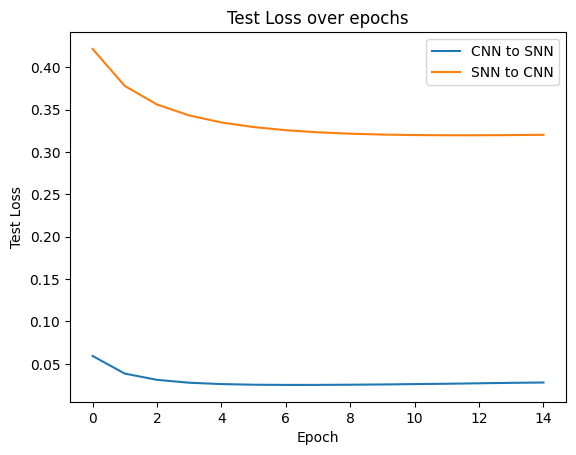

In [123]:
plt.plot(range(15), test_loss_cnn_to_snn, label='CNN to SNN')
plt.plot(range(15), test_loss_snn_to_cnn, label='SNN to CNN')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss over epochs')
plt.legend()
plt.savefig('images/lin_reg_loss.png')
plt.show()

#### 4.2 Kernel visualization in AlexNet (6 points)

Visualize every channel of the first conv kernel (3 points) and second conv kernel (3 points) of a pre-trained AlexNet. How does the kernel look like?

In [47]:
# TODO: add your implementation here.
import torchvision.models as models
model_alexnet = models.alexnet(pretrained=True).features
print(model_alexnet)

# first conv kernel size: [64, 3, 11, 11]
# visualize all 64 channels, each with shape [3, 11, 11] (treat it as an image)
kernel_conv1_weight = model_alexnet[0].weight.data

# second conv kernel size: [192, 64, 5, 5]
# visualize all 192 channels, each with shape [1, 5, 5] (calculate the mean value over 5 channels for each pixel)
kernel_conv2_weight = model_alexnet[3].weight.data

/Users/JosephYu/opt/anaconda3/envs/nbd_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/JosephYu/opt/anaconda3/envs/nbd_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


torch.Size([64, 3, 11, 11])


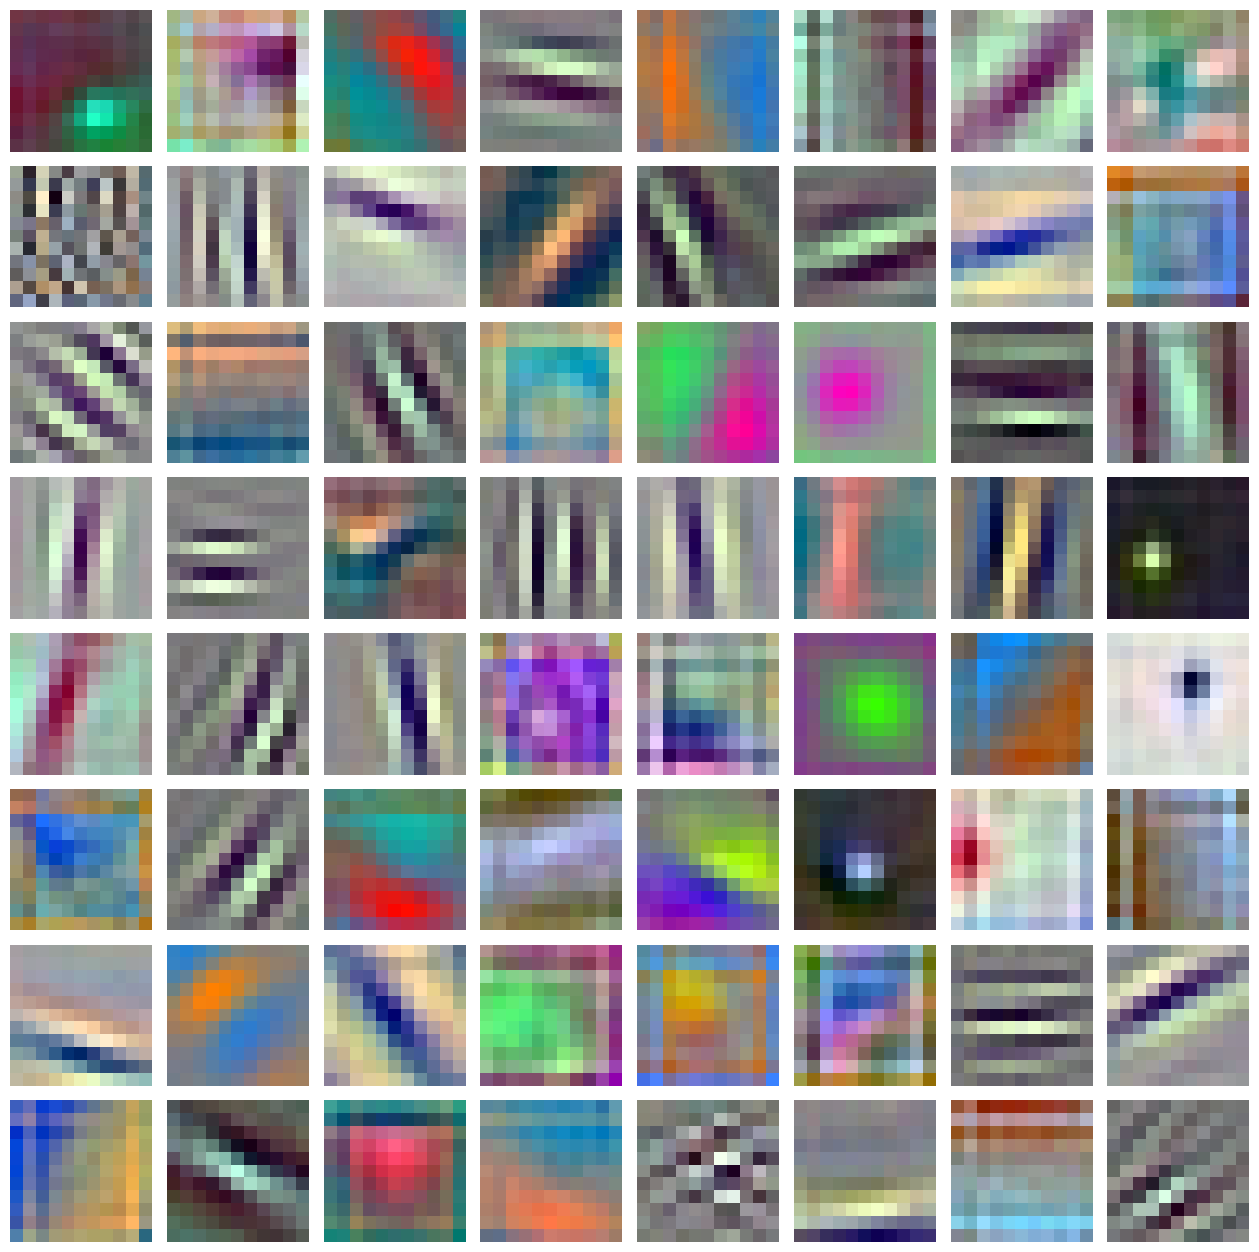

In [126]:
print(kernel_conv1_weight.shape) # [64, 3, 11, 11]

fig, axes = plt.subplots(8, 8, figsize=(8 * 2, 8 * 2))

for i, ax in enumerate(axes.flat):
    kernel = kernel_conv1_weight[i]
    kernel = kernel.permute(1, 2, 0)
    kernel = normalize_kernel(kernel)
    ax.imshow(kernel)
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('images/alexnet_conv1.png')
plt.show()

torch.Size([192, 64, 5, 5])


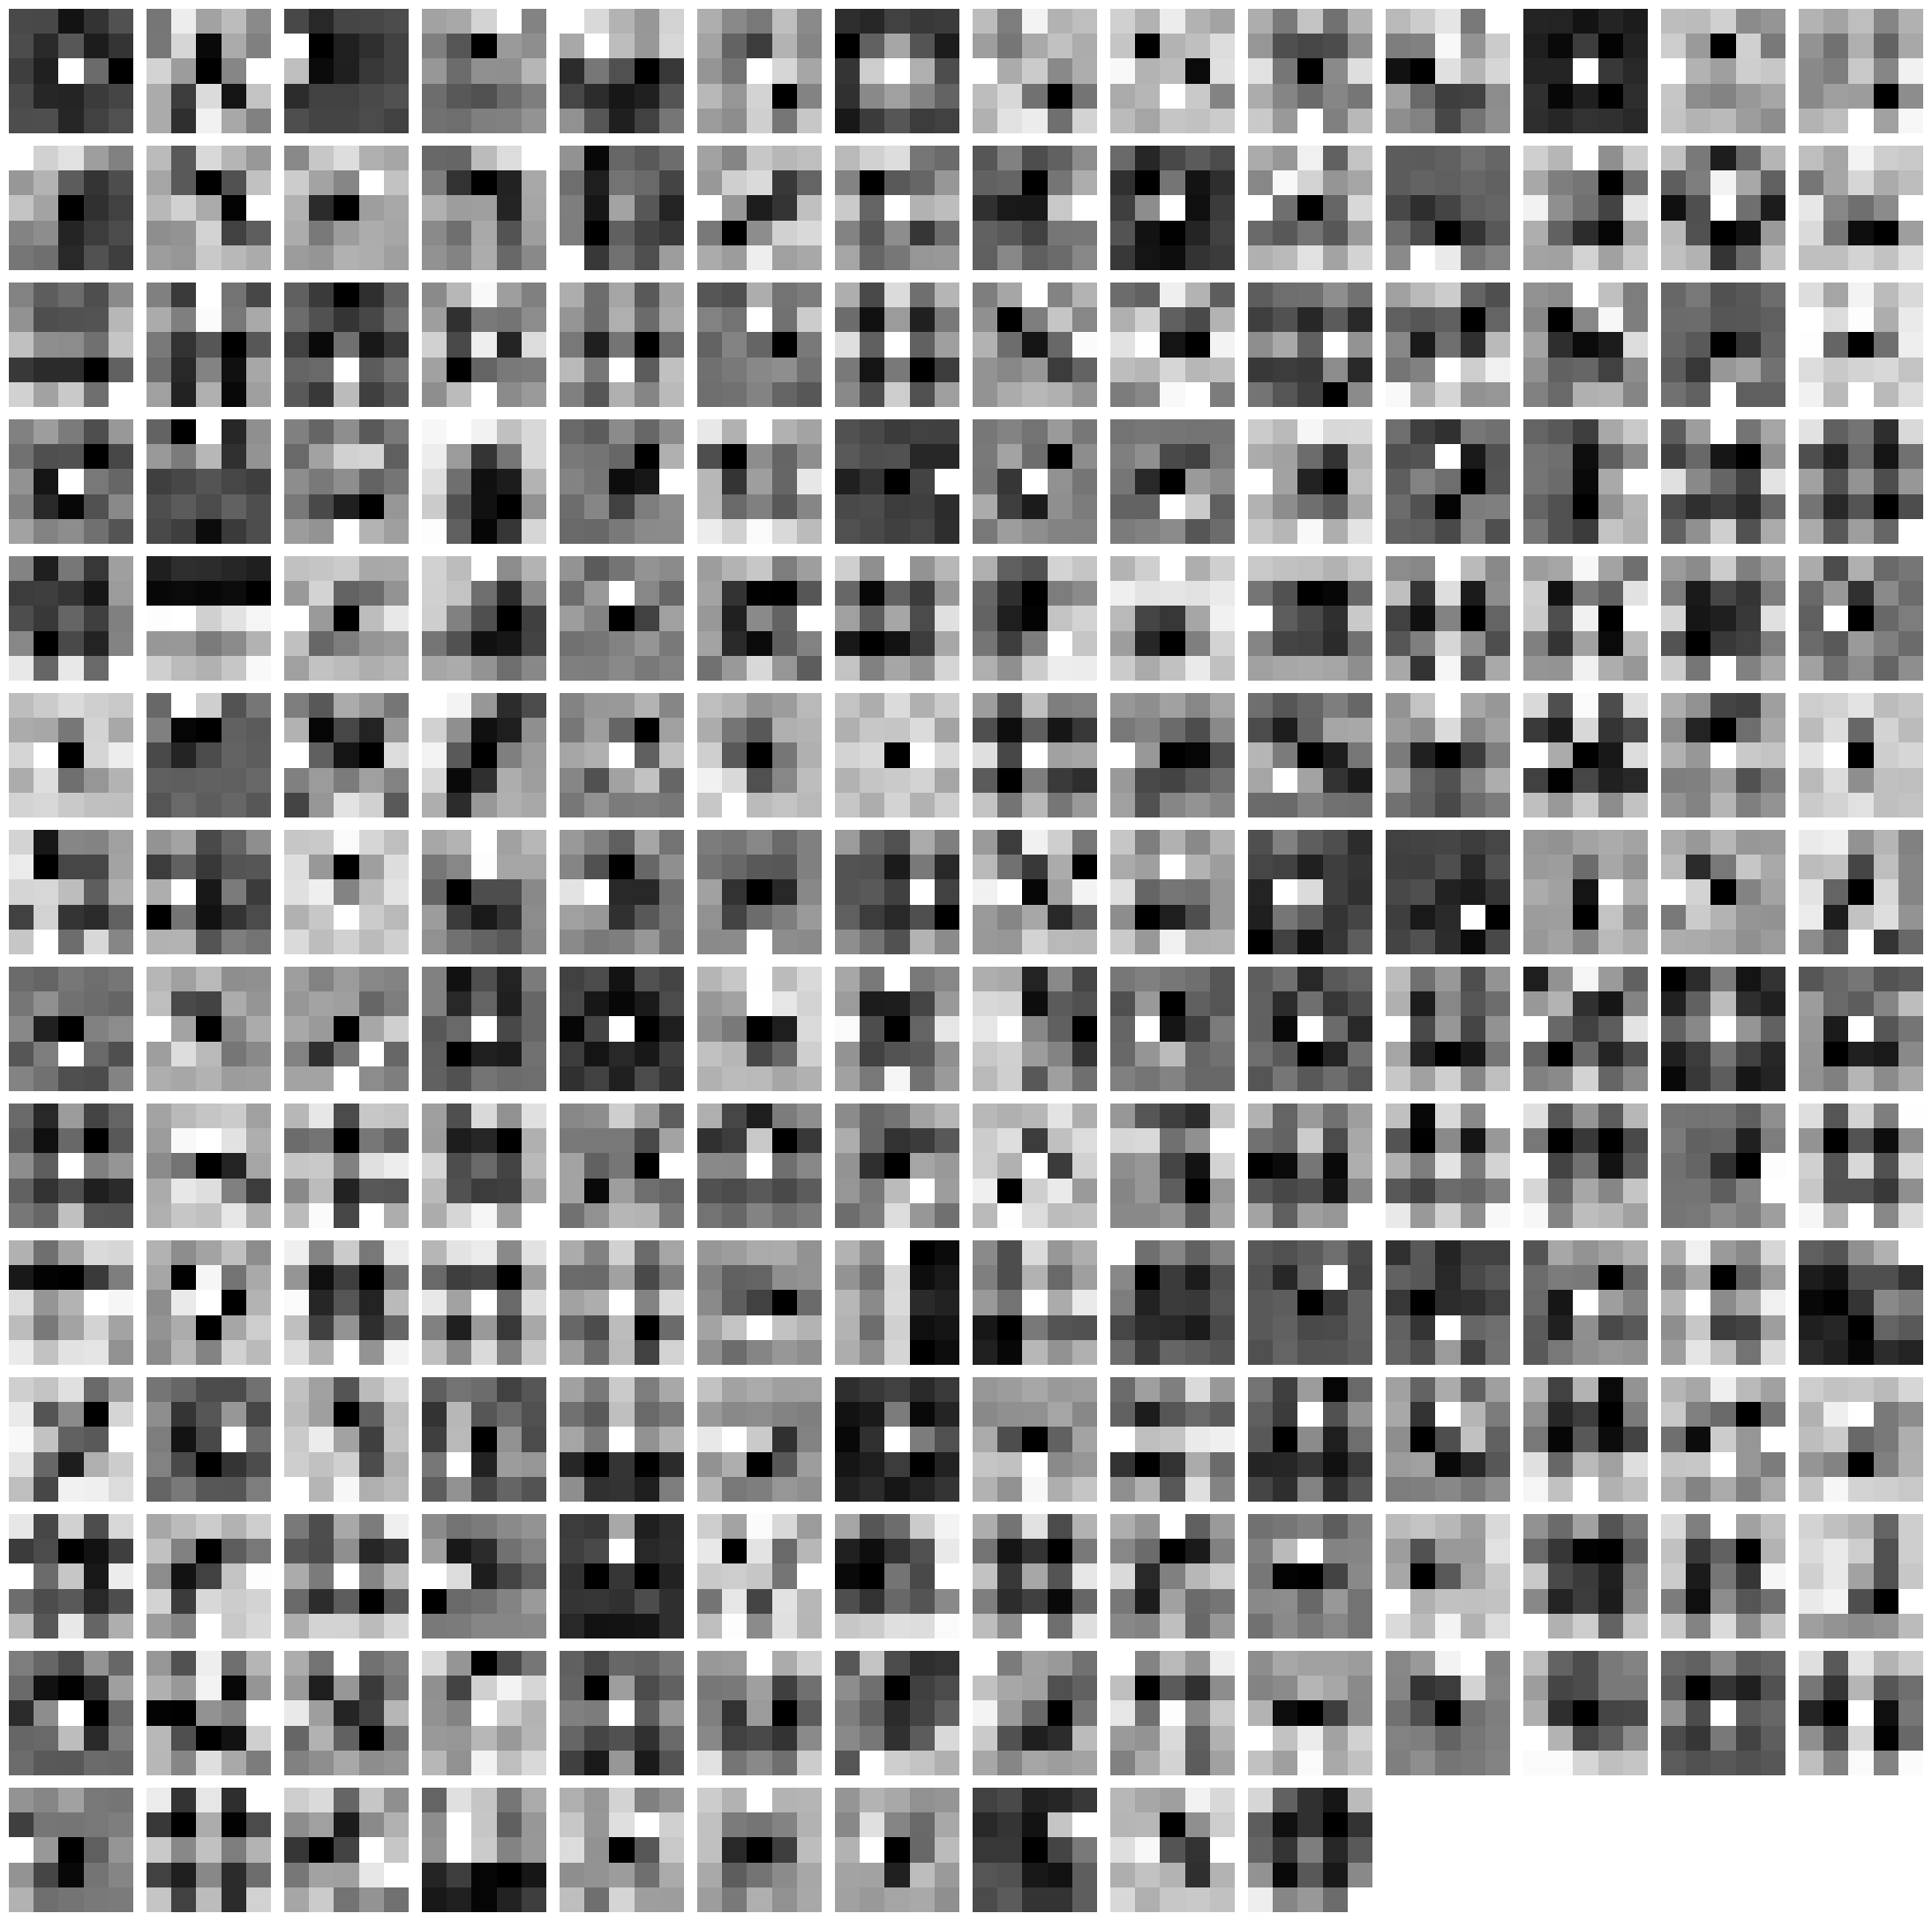

In [128]:
print(kernel_conv2_weight.shape) # [192, 64, 5, 5]

fig, axes = plt.subplots(14, 14, figsize=(14 * 2, 14 * 2))

for i, ax in enumerate(axes.flat):
    if i < kernel_conv2_weight.shape[0]:
        kernel = kernel_conv2_weight[i].mean(0)
        ax.imshow(kernel, cmap='gray')
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('images/alexnet_conv2.png')
plt.show()

#### 4.3 Feature Visualization in AlexNet (6 points)

AlexNet consisting of five convolutional layers followed by three fully connected layers. In this section, choose randomly from the first five convolutional layers on neuron level, channel level, and layer level. Visualize the images to get an understanding of what the neuron is looking for in its receptive field.

In [50]:
# helper functions
import numpy as np
from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt

def show_image(img):
    plt.figure(figsize=[2, 2])
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout(pad=0.5, h_pad=0, w_pad=0)
    plt.show()

def process_image(image, dim=224):
    if isinstance(image, (np.ndarray)):
        im = Image.fromarray(image)
    else:
        im = Image.open(image)

    # convert to a np.array and divide by the color channel (int max)
    np_image = np.array(im) / 255
    # mean and std for ImageNet dataset
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (np_image - mean) / std
    # convert to a Tensor - reorder color channel so it is first. Torch requirement
    image = torch.FloatTensor(image.transpose(2, 0, 1))
    return image

# Rebuilds a Pytorch Tensor with dimensions (1, 3, w, h) and converts it to the necessary format for visualization.
# Reverses the normalization step using the mean and std from the ImageNet dataset.
def rebuild_image(tensor):
    np_image = tensor.detach().numpy()  # convert tensor to nparray
    np_image = np_image.squeeze(0)  # reduce size of tensor
    np_image = np_image.transpose(1, 2, 0)  # reorder color channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (np_image * std + mean)

    return image

In [129]:
class ActivationMaximization():
    # TODO: add your implementation here.
    # HINT: add more parameters here to support different levels
    def __init__(self, model, epochs, cnn_layer_idx, cnn_filter_idx=None, cnn_neuron_idx=None):
        self.model = model
        self.model.eval()  # set model to evaluation mode
        self.epochs = epochs
        self.cnn_layer_idx = cnn_layer_idx
        self.cnn_filter_idx = cnn_filter_idx
        self.cnn_neuron_idx = cnn_neuron_idx
        self.conv_output = 0  # initialize the output of the model for loss

    def hook_cnn_layer(self):
        def hook_fn(module, input, output):
            # Output is of shape [1, channel, height, width]
            if self.cnn_filter_idx == None:
                self.conv_output = output[0]
            elif self.cnn_neuron_idx == None:
                self.conv_output = output[0, self.cnn_filter_idx]
            else:
                h, w = self.cnn_neuron_idx
                self.conv_output = output[0, self.cnn_filter_idx, h, w]

        self.model[self.cnn_layer_idx].register_forward_hook(hook_fn)

    def vis_cnn_layer(self):
        images = []
        # initiate hook function
        self.hook_cnn_layer()
        # create a noisy image
        noisy_img = np.random.randint(125, 190, (224, 224, 3), dtype='uint8')
        # add dimension and activate requires_grad on tensor
        processed_image = process_image(noisy_img).unsqueeze_(0).requires_grad_()
        # define optimizer
        optimizer = optim.Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, self.epochs):
            # TODO: add your implementation here.
            optimizer.zero_grad()
            x = self.model(processed_image)
            loss = -torch.mean(self.conv_output) 
            loss.backward()
            optimizer.step()

            if i % 5 == 0:
                print('loss: ', loss.item())
                img = rebuild_image(processed_image)
                for channel in range(3):
                    img[:, :, channel] = normalize_image(img[:, :, channel])
                    
                images.append(img)

        return images


##### Visualize on channel level (2 points)

In [157]:
# channel level
cnn_layer_idx = 0
cnn_filter_idx = 28
epochs = 51

model_alexnet = models.alexnet(pretrained=True).features

activation_maximization = ActivationMaximization(model_alexnet, epochs, cnn_layer_idx, cnn_filter_idx)
images = activation_maximization.vis_cnn_layer()

loss:  -8.064627647399902
loss:  -19.28243064880371
loss:  -30.701366424560547
loss:  -42.17253112792969
loss:  -53.65239334106445
loss:  -65.12297821044922
loss:  -76.57585906982422
loss:  -88.00694274902344
loss:  -99.41439819335938
loss:  -110.79750061035156


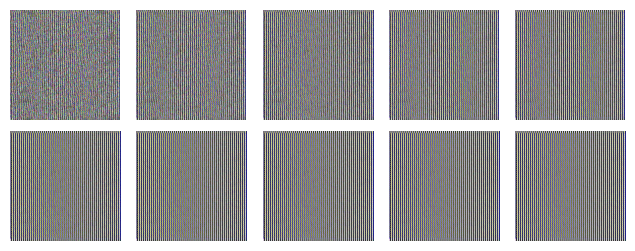

In [158]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('images/alexnet_layer0_filter28.png')
plt.show()

##### Visualize on neuron level (2 points)

In [155]:
# neuron level
cnn_layer_idx = 6
cnn_filter_idx = 20
cnn_neuron_idx = (5, 5)
epochs = 51

model_alexnet = models.alexnet(pretrained=True).features

activation_maximization = ActivationMaximization(model_alexnet, epochs, cnn_layer_idx, cnn_filter_idx, cnn_neuron_idx)
images = activation_maximization.vis_cnn_layer()

loss:  -57.68846893310547
loss:  -157.0397186279297
loss:  -263.2465515136719
loss:  -377.0047912597656
loss:  -496.2243347167969
loss:  -617.61181640625
loss:  -740.7463989257812
loss:  -867.4496459960938
loss:  -995.8235473632812
loss:  -1125.3524169921875


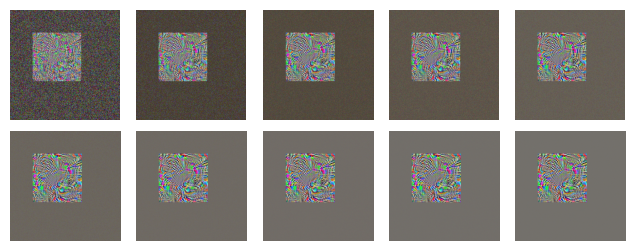

In [156]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('images/alexnet_layer6_filter20_neuron5_5.png')

##### Visualize on layer level (2 points)

In [151]:
# layer level
cnn_layer_idx = 12
epochs = 51

model_alexnet = models.alexnet(pretrained=True).features

activation_maximization = ActivationMaximization(model_alexnet, epochs, cnn_layer_idx)
images = activation_maximization.vis_cnn_layer()

loss:  -2.662931442260742
loss:  -8.458948135375977
loss:  -15.18437671661377
loss:  -22.634267807006836
loss:  -30.61442756652832
loss:  -39.03809356689453
loss:  -47.96061325073242
loss:  -57.22059631347656
loss:  -66.6626968383789
loss:  -76.28520965576172


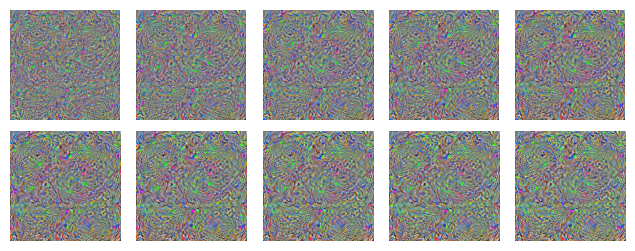

In [152]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('images/alexnet_layer12.png')
plt.show()

#### 4.4 Bonus: Feature visualization for SNN (4 points)

Use mean image mechanism mentioned before to find best spike train input for SNN on neuron level, channel level, and layer level.

In [99]:
def top_k_images_snn(model, T=50, k=5, layer_index=0, channel_index=None, neuron_index=None):
    # set the model to evaluation mode
    model.eval()
    images = []
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

    # disable gradient calculation
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            data = data / 2 + 0.5
            output_fr, convbn1_r, convbn2_r = model(gen_spike_data_bernoulli(data, T))
            for i in range(data.size(0)):
                layer = convbn2_r[i] if layer_index == 1 else convbn1_r[i]
                if channel_index != None:
                    layer = layer[channel_index]
                if neuron_index != None:
                    layer = layer[neuron_index[0], neuron_index[1]]
                images.append((data[i], torch.mean(layer)))
                
    images.sort(key=lambda x: x[1], reverse=True)
    return torch.stack([image[0].squeeze(0) for image in images[:k]])

In [111]:
model_snn_vis = SNN_KernelVisualization(T).to(device)
model_snn_vis.load_state_dict(torch.load('best_model_snn.pth', weights_only=True))

In [159]:
# Display mean of images for layer 
layer = 1 # 0 for convbn1, 1 for convbn2
k_images = top_k_images_snn(model_snn_vis, T, k = 20, layer_index=layer)
k_images_mean = torch.mean(k_images, dim=0)
k_images_mean_np_layer = k_images_mean.permute(1, 2, 0).cpu().numpy()


In [160]:
# Display mean of images for layer and channel
layer = 0 # 0 for convbn1, 1 for convbn2
channel = 15
k_images = top_k_images_snn(model_snn_vis, T, k = 20, layer_index=layer, channel_index=channel)
k_images_mean = torch.mean(k_images, dim=0)
k_images_mean_np_channel = k_images_mean.permute(1, 2, 0).cpu().numpy()

In [161]:
# Display mean of images for layer, channel and neuron
layer = 1 # 0 for convbn1, 1 for convbn2
channel = 15
neuron = (7, 5)
k_images = top_k_images_snn(model_snn_vis, T, k = 20, layer_index=layer, channel_index=channel, neuron_index=neuron)
k_images_mean = torch.mean(k_images, dim=0)
k_images_mean_np_neuron = k_images_mean.permute(1, 2, 0).cpu().numpy()

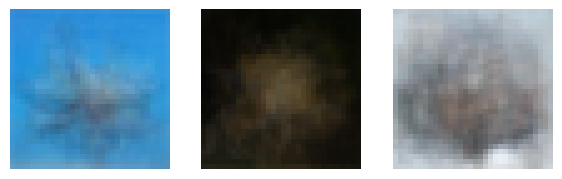

In [164]:
fig, axes = plt.subplots(1, 3, figsize=(7, 3))
k_mean_images = [k_images_mean_np_layer, k_images_mean_np_channel, k_images_mean_np_neuron]
for i, ax in enumerate(axes):
    ax.imshow(k_mean_images[i])
    ax.axis('off')

axes[0].axis('off')
plt.savefig('images/snn_mean_images.png')
plt.show()